# Setup

Import necessary modules and do some basic setup.

In [33]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

# Common imports
import os
import glob
import seaborn
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

# Custom utils for processing the data
from utils_data import * 
from utils_ml import *
from utils_plot import *

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils_data import *

Define some paths and constants.

In [34]:
# Paths
DATADIR = os.getcwd() + '/../data'

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]

# Unsupervised learning approaches

## Getting started with the data

### Exploratory analysis

In [35]:
# Open MSLP data
mslp = xr.open_mfdataset(DATADIR + '/ERA5/Day_era5_2deg_MSL_EU_1979-2021.nc',
                         combine='by_coords')

mslp = mslp.sel(time=slice(DATE_START, DATE_END))

# Convert to hPa
mslp.MSL.values = mslp.MSL.values/100
lon = mslp.lon
lat = mslp.lat

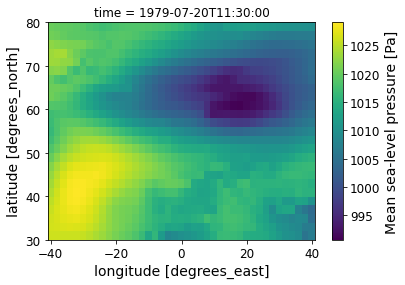

In [36]:
# Plot an example (day) of mslp
mslp.MSL.isel(time=200).plot()

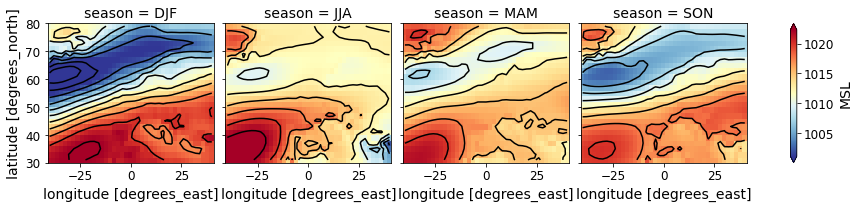

In [37]:
# Process season mean
season_means = mslp.groupby("time.season").mean()

fg = season_means.MSL.plot(col="season", col_wrap=4,
                           robust=True, cmap=mpl.cm.RdYlBu_r)

# Plot contours
fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)


In [38]:
# Compute climatology (total and by season)
climatology = mslp.mean('time')
climatology_seasons = mslp.groupby('time.season').mean('time')

# Compute anomalies (total and by season)
anom_mslp = mslp.MSL - climatology
anom_mslp_seasons = mslp.groupby('time.season') - climatology_seasons

## PCA analysis

We start using PCA for dimensionality reduction of the whole data. 

In [39]:
# We need to reshape the data [time,latxlon]
mslp_stacked = mslp.stack(latlon=('lat', 'lon'))

# Load in memory for computing the PCA
mslp_stacked.load()

# Extract msl variable
X = mslp_stacked.MSL

The number of variables (features) is 1025 (41 points in longitude * 25 points in latitude)

In [40]:
# Standardise the data
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

In [41]:
# Do the PCA
pca = PCA()
pca.fit(X)

cumsum = np.cumsum(pca.explained_variance_ratio_)
nb_pc_90 = np.argmax(cumsum >= 0.90) + 1
nb_pc_95 = np.argmax(cumsum >= 0.95) + 1

print(f'Number of PC to explain 90% of the variance: {nb_pc_90}')
print(f'Number of PC to explain 95% of the variance: {nb_pc_95}')

Number of PC to explain 90% of the variance: 12
Number of PC to explain 95% of the variance: 18


Text(0, 0.5, '% variance')

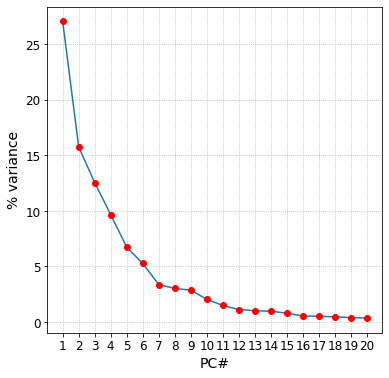

In [42]:
# Plot component contributions
f, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1,21), pca.explained_variance_ratio_[0:20]*100)
ax.plot(range(1,21), pca.explained_variance_ratio_[0:20]*100,'ro')
ax.grid(ls=':')
ax.set_xticks(range(1,21))
ax.set_xlabel('PC#')
ax.set_ylabel("% variance")

In [43]:
# Select 12 components (explaining 90% of the variance)
nb_pc = nb_pc_90
pca.explained_variance_ratio_[:nb_pc].sum()

0.9095372

In [44]:
PCs = pca.fit_transform(X)
PCs_n = PCs[:, :nb_pc]

# Data frame format for the selected components
PCdf = pd.DataFrame(PCs_n, index=mslp['time'],
                    columns=["PC%s" % (x) for x in range(1, PCs_n.shape[1] + 1)])

# See the data
PCdf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
1979-01-01 11:30:00,-16.418085,11.950503,-5.762707,1.175341,-1.295121,-12.934866,10.681583,-3.226187,4.876585,-5.170130,15.477432,-2.655034
1979-01-02 11:30:00,-17.796597,3.597052,-7.132586,4.788782,-11.373435,-9.849724,-0.240520,-7.078946,3.405920,-3.277301,13.131650,-2.296521
1979-01-03 11:30:00,-13.354214,3.901716,-1.463021,0.669005,-8.666795,0.402837,-12.197273,-0.135387,-3.643520,-11.297833,10.841182,-5.282046
1979-01-04 11:30:00,-15.807054,0.808467,-0.970602,-7.491268,1.753537,13.026252,-2.040822,18.791342,-2.844063,-2.369415,5.189134,-8.058639
1979-01-05 11:30:00,3.823341,-9.783282,-8.731400,-14.646765,11.747644,2.965687,-4.057940,23.074621,2.829855,3.896114,7.092285,-7.420454


The EOFS (Empirical orthogonal functions) contain the spatial patterns associated with each PC
***$\color{blue}{\text{In climate studies, EOF analysis is often used to study possible spatial modes (ie, patterns)}}$***

In [45]:
EOFs = pca.components_
EOFs = EOFs[:nb_pc, :]

# Reshape the data
EOFs_r = EOFs.reshape((nb_pc, len(lat), len(lon)))
EOFs_r.shape

(12, 25, 41)

Visualise each pattern (i.e. spatially the PCA)

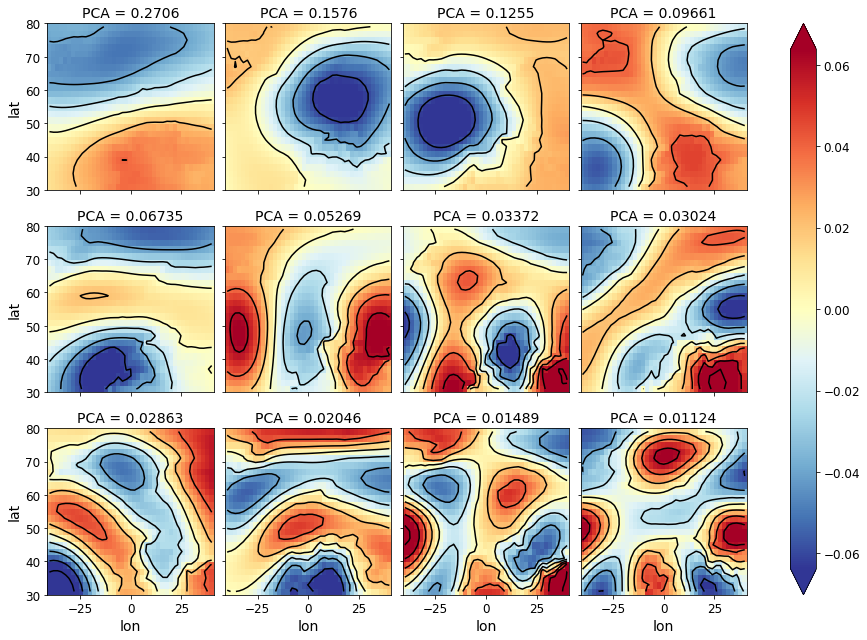

In [46]:
# Convert into Xarray for visualization
exp_var = pca.explained_variance_ratio_[:nb_pc]
XD_EOFs_r = xr.DataArray(data=EOFs_r, coords=[("PCA", exp_var), ("lat", lat.data), ("lon", lon.data)])

fg = XD_EOFs_r.plot(col="PCA", col_wrap=4, robust=True, cmap=mpl.cm.RdYlBu_r)

fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)


## K-means clustering

Next step, we apply K-means clustering algorithm using the PCs from the previous analysis.  

In [47]:
# Perform K-cluster analysis using the PCds obtained before
nclusters = 12 #(number of PCs)
kmeans = KMeans(init='k-means++', n_clusters=nclusters, n_init=10)
kmeans.fit(PCdf.values)
y_pred = kmeans.fit_predict(PCdf.values)

# Each day belongs to a cluster, labelled by kmeands.labels_
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [48]:
labels = pd.DataFrame(kmeans.labels_, index=np.array(mslp['time']), columns=['cluster'])

In [49]:
# Now, we can look at the number of days belong to cluster 0
index = labels.query('cluster == {}'.format(0))
len(index)

683

For illustration purposes, next, we calculate the mean of each cluster. 
This will show the pressure patterns corresponding to each cluster. 

In [51]:
num_tot = len(labels.cluster)
clusters = []
day_clusters = []
nbdays = []

for i_clus in range(nclusters):
    index = labels.query('cluster == {}'.format(i_clus))
    freq = (len(index)/num_tot)*100
    freq = round(freq, 2)
    nbdays.append(freq)
    cluster = mslp.sel(time=index.index).mean('time')
    d_cluster = mslp.sel(time=index.index)
    clusters.append(cluster)
    day_clusters.append(d_cluster)

clusters = xr.concat(clusters, dim='cluster')
clusters.assign_coords(cluster=nbdays)

<xarray.Dataset>
Dimensions:  (lon: 41, lat: 25, cluster: 12)
Coordinates:
  * lon      (lon) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... 34.0 36.0 38.0 40.0
  * lat      (lat) float64 31.0 33.0 35.0 37.0 39.0 ... 71.0 73.0 75.0 77.0 79.0
  * cluster  (cluster) float64 4.45 7.52 7.97 10.77 9.78 ... 5.94 5.9 6.48 13.62
Data variables:
    MSL      (cluster, lat, lon) float32 1.025e+03 1.025e+03 ... 1.009e+03

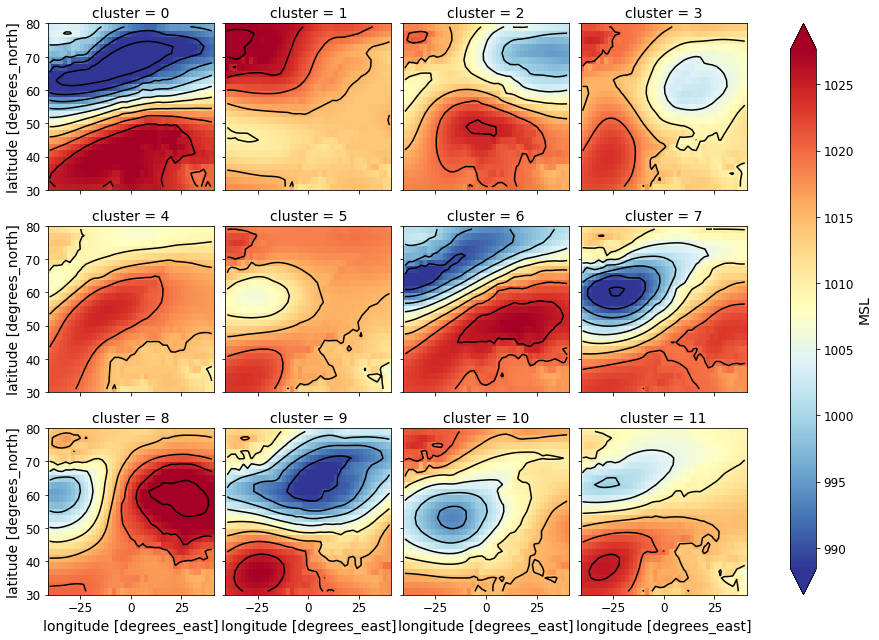

In [52]:
fg_c = clusters.MSL.plot(col="cluster",  col_wrap=4, robust=True, cmap=mpl.cm.RdYlBu_r)

fg_c.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

Process the outputs for the next steps (supervised classic methods and deep learning)

In [58]:
# Save PCs and Clusters
PCdf['date'] = PCdf.index
PCdf.to_csv(DATADIR + 'PCdf.csv', index=False)

In [59]:
def prepare_cluster_data(day_clusters):
    t_list = []
    for i_clus in range(len(day_clusters)):
        tmp = day_clusters[i_clus].mean(dim=['lon', 'lat'])
        tmp_df = pd.DataFrame({'date': tmp['time'], 'MSL': tmp['MSL'], 'Cluster': i_clus})
        t_list.append(tmp_df)

    # Merge by date
    df = pd.concat(t_list)
    df = df.sort_values(by="date")
    return(df)


In [60]:
cluster_spatial_mean = prepare_cluster_data(day_clusters)
cluster_spatial_mean.head()

,date,MSL,Cluster
0,1979-01-01 11:30:00,1013.507629,3
0,1979-01-02 11:30:00,1017.233826,5
1,1979-01-03 11:30:00,1016.426819,5
2,1979-01-04 11:30:00,1016.511230,5
0,1979-01-05 11:30:00,1013.134155,4


In [61]:
cluster_spatial_mean.to_csv(DATADIR + 'Cluster_spatialmean.csv', index=False)

# Supervised learning approaches

## Data preparation

## Target: precipitation

In [64]:
df_prec = get_precipitation_data(DATADIR + '/MeteoSwiss/precip_regions.csv', DATE_START, DATE_END)

# Select the right columns: date and reg_tot (whole country)
df_prec = df_prec[['date', 'reg_tot']]

### Input variables
A set of primary meteorological variables are used as covariates.
- Geopotential levels (1000, 850, 700, 500, 300)
- MSL: Mean sea level pressure
- T2MMEAN: 2m-temperature

**Extra-variables such as lagged T2MMEAN and PCs will be used (see below)**

In [66]:
# Prepare the dataset
l_files = glob.glob(os.path.join(DATADIR, 'ERA5', 'TS_CH', 'df*.csv'))
df_vars = read_csv_files(l_files, DATE_START, DATE_END)
df_vars.head()

,date,1000,850,700,500,300,MSL,T2MMEAN
0,1979-01-01,68.369168,1340.679233,2808.103073,5257.976679,8709.221804,1009.0970,-9.09492
1,1979-01-02,199.460040,1441.089057,2869.504877,5237.282864,8605.786890,1026.4789,-16.21680
2,1979-01-03,187.244992,1449.997094,2913.765761,5340.855440,8780.448981,1024.0898,-13.92896
3,1979-01-04,72.769284,1356.885379,2861.477875,5356.089286,8819.888545,1009.1322,-13.54580
4,1979-01-05,127.660414,1424.216323,2942.889264,5446.512316,8893.579357,1015.9122,-12.99600


In [67]:
# Add lag-t2mmean: For precipiation the memory system is important, adding lagged variables might help to predict precipitation
df_vars['T2MLag'] = df_vars['T2MMEAN'].shift(1)
df_vars.head()

,date,1000,850,700,500,300,MSL,T2MMEAN,T2MLag
0,1979-01-01,68.369168,1340.679233,2808.103073,5257.976679,8709.221804,1009.0970,-9.09492,NaN
1,1979-01-02,199.460040,1441.089057,2869.504877,5237.282864,8605.786890,1026.4789,-16.21680,-9.09492
2,1979-01-03,187.244992,1449.997094,2913.765761,5340.855440,8780.448981,1024.0898,-13.92896,-16.21680
3,1979-01-04,72.769284,1356.885379,2861.477875,5356.089286,8819.888545,1009.1322,-13.54580,-13.92896
4,1979-01-05,127.660414,1424.216323,2942.889264,5446.512316,8893.579357,1015.9122,-12.99600,-13.54580


#### Use PCs from the previous steps (PCA-analysis)

In [76]:
# Read Large scale-atmospheric PCs and Clusters
df_PCs = pd.read_csv(DATADIR + '/ERA5/PCdf.csv')
df_PCs['date'] = pd.DatetimeIndex(df_PCs['date']).normalize()
df_clusters = pd.read_csv(DATADIR + '/ERA5/Cluster_spatialmean.csv')
df_clusters = df_clusters[['date', 'Cluster']]
df_clusters['date'] = pd.DatetimeIndex(df_clusters['date']).normalize()

In [77]:
# Merge everything
l_all = [df_vars, df_prec]
df_all = concat_dataframes(l_all)

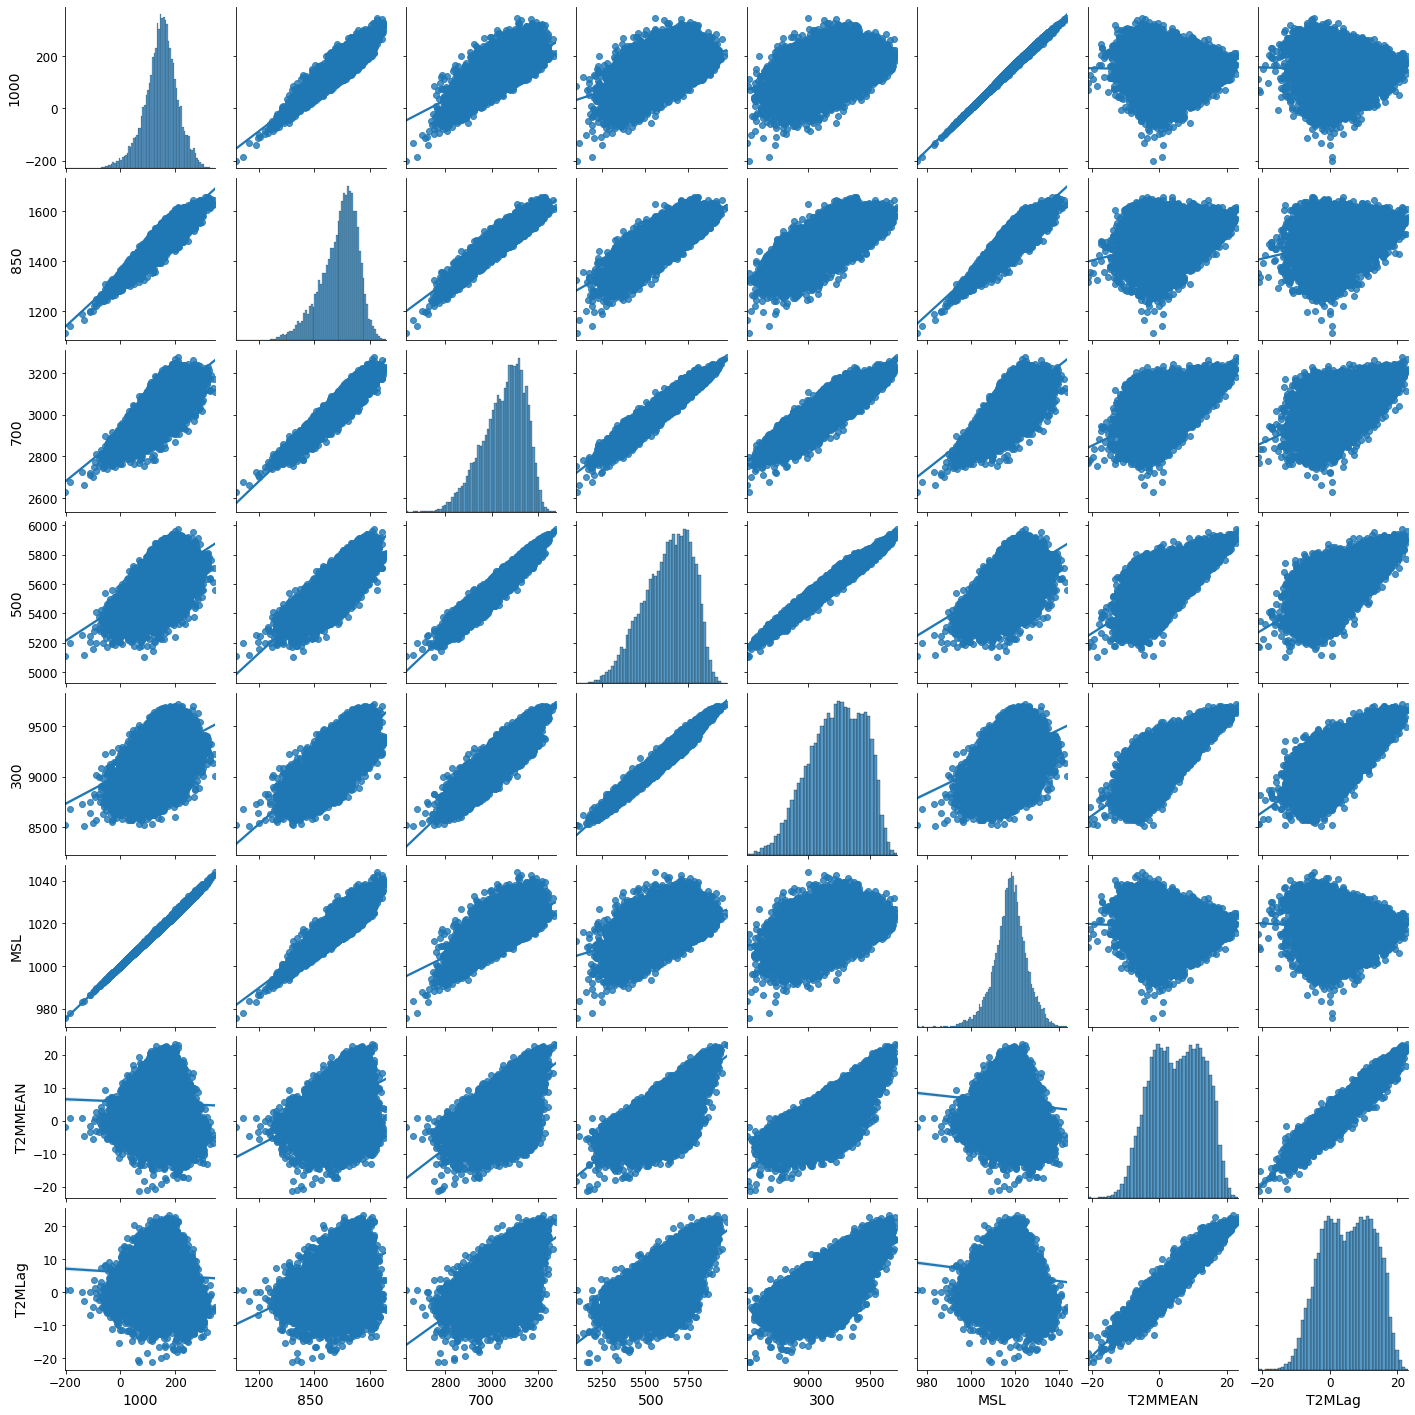

In [70]:
# Data exploration
seaborn.pairplot(df_all, vars=df_all.columns[1:9],
                 kind='reg')

In [79]:
ylabel = df_prec.columns[1]

# Merge the meteorological covariates and the PCs from the previous analaysis
df_input = pd.merge(df_all, df_PCs)
names_col = df_input.columns


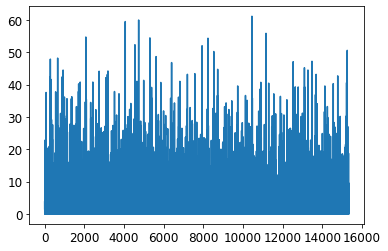

In [80]:
# Visualize the target variable: precipitation
df_input['reg_tot'].plot()
plt.show()

In [81]:
# Define attributes - i.e covariates: remove MSL as using the PCs
attributes = names_col.drop(['date','reg_tot','MSL'])

# Split data into training and test
train_dataset, train_labels, test_dataset, test_labels, train_dates, test_dates = split_data(df_input, YY_TRAIN, YY_TEST, attributes, ylabel)

In [84]:
# In case of using the clusters, it has to be a categorical variable: cat_var='Cluster'
# In the following we won't use categorical variables, as we're using the PCs
fpipeline = create_pipeline(train_dataset, None)
X_prep_train = fpipeline.fit_transform(train_dataset)
X_prep_test = fpipeline.transform(test_dataset)

In [85]:
X_prep_train

array([[-1.31781156, -2.22765385, -2.65748443, ..., -1.13282228,
         3.96344771, -0.77558123],
       [ 0.86935883, -0.73208678, -1.98373903, ..., -0.71871146,
         3.36283515, -0.67031718],
       [ 0.66555829, -0.59940488, -1.4980763 , ..., -2.47343341,
         2.77638516, -1.54690525],
       ...,
       [ 1.44539586,  1.22910784,  0.86893688, ..., -2.85278   ,
        -1.41559708,  0.82296579],
       [ 1.21611002,  0.88593212,  0.60448991, ..., -1.06804642,
        -0.0447976 ,  0.42091711],
       [ 1.00952575,  0.68483682,  0.34034057, ..., -1.82390228,
        -1.3956736 ,  0.93728885]])

## 1. Multiple Linear regression for precipitation values

In [86]:
lr = LinearRegression(n_jobs=16)
lr.fit(X_prep_train, train_labels)

LinearRegression(n_jobs=16)

In [87]:
mse_train = mean_squared_error(train_labels, lr.predict(X_prep_train))
mse_test = mean_squared_error(test_labels, lr.predict(X_prep_test))

print(f'Train MSE = {mse_train}')
print(f'Test MSE = {mse_test}')
print(f'Train RMSE = {np.sqrt(mse_train)}')
print(f'Test RMSE = {np.sqrt(mse_test)}')

Train MSE = 24.98047373483908
Test MSE = 23.33296828309307
Train RMSE = 4.998046992059907
Test RMSE = 4.830421128958951


In [88]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
lr_cv_mse = cross_val_score(lr, X_prep_train, train_labels, scoring='neg_mean_squared_error', cv=10)

# We got the negative average MSE for cross-validation (minimizing MSE is equivalent to maximizing the negative MSE)
lr_cv_mse.mean()
# The result is close to what we obtained before. The negative result 

-25.078757560749345

In [89]:
lin_rmse_scores = np.sqrt(-lr_cv_mse)
pd.Series(lin_rmse_scores).describe()

count    10.000000
mean      5.001225
std       0.271833
min       4.746833
25%       4.776600
50%       4.913249
75%       5.134006
max       5.463926
dtype: float64

In [90]:
print(f"Folds: {len(lr_cv_mse)}, MSE: {np.mean(np.abs(lr_cv_mse))}, STD: {np.std(lr_cv_mse)}")


Folds: 10, MSE: 25.078757560749345, STD: 2.6327001394209364


In [91]:
# Get the coefficients
lr.coef_
# coeff_df = pd.DataFrame(lr.coef_, attributes, columns=['Coefficient'])
# makes some predictions
y_pred = lr.predict(X_prep_test)

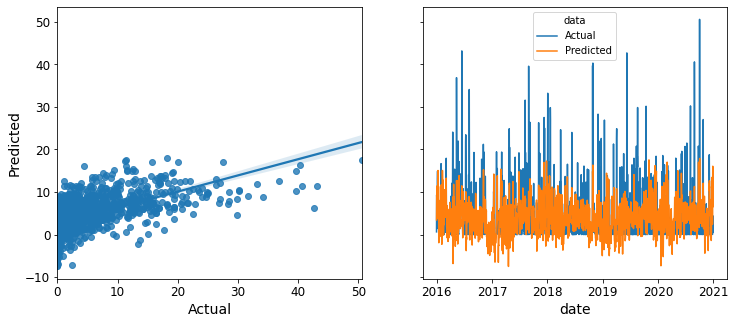

In [92]:
plot_prediction_ts(test_dates, y_pred, test_labels)

***Additional test: Since we're getting negative predicted values, let's try to transform the target variable***

Let's transform the target variable as **log(prec)** and use same linear model

In [93]:

regr_trans = TransformedTargetRegressor(regressor=LinearRegression(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)

regr_trans.fit(X_prep_train, train_labels)
y_trans_pred = regr_trans.predict(X_prep_test)

In [94]:
mse_transf_train = mean_squared_error(train_labels, regr_trans.predict(X_prep_train))
mse_transf_test = mean_squared_error(test_labels, regr_trans.predict(X_prep_test))
print(f'Train MSE = {mse_transf_train}'); print(f'Test MSE = {mse_transf_test}')
print(f'Train RMSE = {np.sqrt(mse_transf_train)}'); print(f'Test RMSE = {np.sqrt(mse_transf_test)}')

Train MSE = 28.989235315809996
Test MSE = 25.980474089480428
Train RMSE = 5.38416523853141
Test RMSE = 5.097104480926443


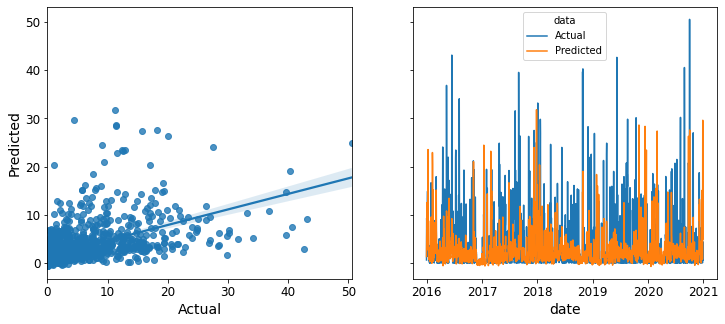

In [95]:
# Plot predictions
plot_prediction_ts(test_dates, y_trans_pred, test_labels)

*The predicted values against observations look better now

## 2. Random Forest

We apply now a random forest model using same predictors.

In [97]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_prep_train, train_labels)

# Make predictions
y_rf_pred = forest_reg.predict(X_prep_test)

In [98]:
mse_rf_train = mean_squared_error(train_labels, forest_reg.predict(X_prep_train))
mse_rf_test = mean_squared_error(test_labels, forest_reg.predict(X_prep_test))
print(f'Train MSE = {mse_rf_train}'); print(f'Test MSE = {mse_rf_test}')
print(f'Train RMSE = {np.sqrt(mse_rf_train)}'); print(f'Test RMSE = {np.sqrt(mse_rf_test)}')

Train MSE = 3.2643481961414533
Test MSE = 21.913815165302243
Train RMSE = 1.806750728833796
Test RMSE = 4.681219410079199


We can see overfitting problem...

### Tuning parameter

In [112]:
# Create the parameter grid based on the results of random search
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 40], 'max_features': [2, 4, 12]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 6]},
]

forest_reg = RandomForestRegressor(random_state=42)

# Train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_prep_train, train_labels)
best_params = grid_search.best_params_

In [113]:
print("Best Score:", grid_search.best_score_)
print("Best params:", best_params)

Best Score: -24.19216036425596
Best params: {'max_features': 12, 'n_estimators': 40}


In [114]:
forest_GCV_reg = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
forest_GCV_reg.fit(X_prep_train, train_labels)

RandomForestRegressor(max_features=12, n_estimators=40, n_jobs=-1)

In [115]:
y_rf_cv_predict = forest_GCV_reg.predict(X_prep_test)
mse_rf_cv_train = mean_squared_error(train_labels, forest_GCV_reg.predict(X_prep_train))
mse_rf_cv_test = mean_squared_error(test_labels, forest_GCV_reg.predict(X_prep_test))
print(f'Train MSE = {mse_rf_cv_train}')
print(f'Test MSE = {mse_rf_cv_test}')
print(f'Train RMSE = {np.sqrt(mse_rf_cv_train)}')
print(f'Test RMSE = {np.sqrt(mse_rf_cv_test)}')


Train MSE = 3.4506165706796192
Test MSE = 21.892803818524907
Train RMSE = 1.857583529933343
Test RMSE = 4.678974654614503


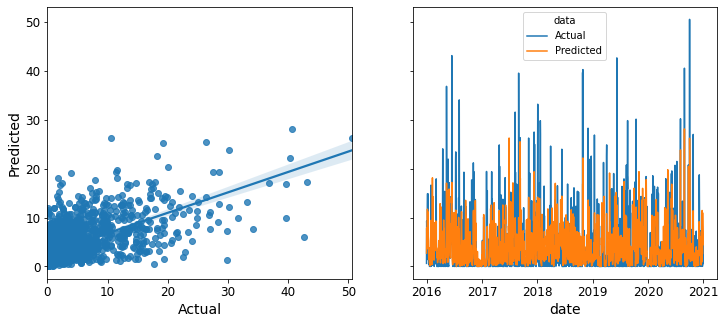

In [116]:
plot_prediction_ts(test_dates, y_rf_cv_predict, test_labels)

Now, let's look at the features importance, which are the most important covariates? 

In [119]:
features_importance = forest_GCV_reg.feature_importances_
sorted_features_importance = sorted(zip(features_importance, attributes), reverse=True)
sorted_features_importance

[(0.18084768256933853, '1000'),
 (0.09744746233212753, 'T2MLag'),
 (0.08288640528767552, '850'),
 (0.061138446874949556, 'PC5'),
 (0.054234684403914414, 'PC2'),
 (0.050033926157104926, 'PC11'),
 (0.04963354876812284, 'PC1'),
 (0.04873501160398773, 'T2MMEAN'),
 (0.043508929164962386, 'PC7'),
 (0.042817065776071084, 'PC10'),
 (0.04003609315104918, 'PC6'),
 (0.03638491572429563, 'PC9'),
 (0.03536557091724987, 'PC3'),
 (0.034693668359419345, 'PC12'),
 (0.033890865701062006, '300'),
 (0.030134532453195795, 'PC8'),
 (0.027640246247800333, '700'),
 (0.027401898368342847, 'PC4'),
 (0.023169046139330483, '500')]

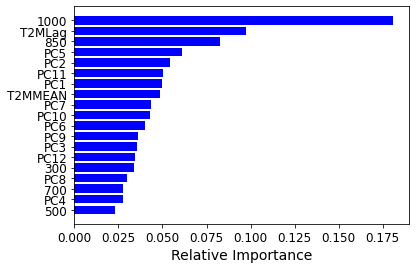

In [120]:
indices = np.argsort(features_importance)
plt.barh(range(len(attributes)), features_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


# Predicting extremes

## 1. Logistic Regression

In [135]:
# define exceedances based on the 95th
df_prec_ex = precip_exceedance(df_prec)
df_prec_ex['reg_tot'] = df_prec_ex['reg_tot']*1

In [141]:
p95 = np.percentile(df_prec['reg_tot'], 95)

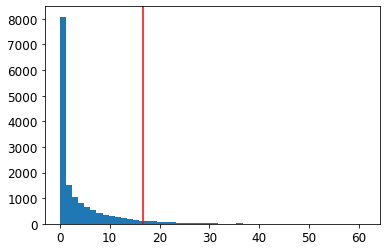

In [143]:
# Visualise the distribution
plt.hist(df_prec['reg_tot'], 50)
plt.axvline(p95, color='r')
plt.show()


In [144]:
df_input_ex = df_input

# Replace reg_tot by the exceedances
df_input_ex['reg_tot'] = df_prec_ex['reg_tot']

In [145]:
train_dataset, train_labels, test_dataset, test_labels, train_dates, test_dates = split_data(df_input_ex, YY_TRAIN, YY_TEST, attributes, ylabel)
# but the data is already in the format (only the labels have been replace by the exceedances)

In [146]:
# All parameters not specified are set to their defaults
logistic_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_reg.fit(X_prep_train, train_labels)

LogisticRegression(max_iter=1000)

In [147]:
y_ex_pred = logistic_reg.predict(X_prep_test)

In [148]:
cnf_matrix = confusion_matrix(test_labels, y_ex_pred)
print(cnf_matrix)

[[1727   18]
 [  66   16]]


In [149]:
# Use score method to get accuracy of model
score = logistic_reg.score(X_prep_test, test_labels)
print(score)

0.9540229885057471


In [150]:
print(classification_report(test_labels, y_ex_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1745
           1       0.47      0.20      0.28        82

    accuracy                           0.95      1827
   macro avg       0.72      0.59      0.63      1827
weighted avg       0.94      0.95      0.94      1827



In [151]:
# Make probability predictions
train_probs = logistic_reg.predict_proba(X_prep_train)[:, 1]
probs = logistic_reg.predict_proba(X_prep_test)[:, 1]

train_predictions = logistic_reg.predict(X_prep_train)
predictions = logistic_reg.predict(X_prep_test)
print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 0.9116321199745332
Test ROC AUC  Score: 0.9132923334964009


Recall Baseline: 1.0 Test: 0.2 Train: 0.21
Precision Baseline: 0.04 Test: 0.47 Train: 0.66
Roc Baseline: 0.5 Test: 0.91 Train: 0.91


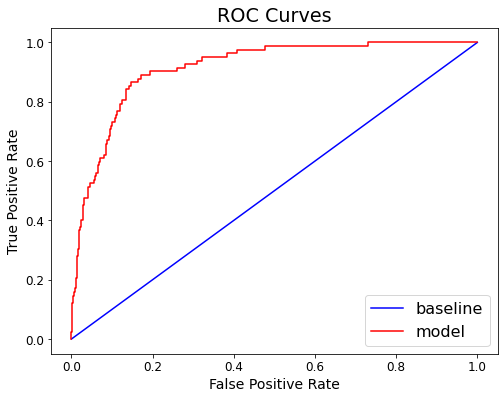

In [152]:
evaluate_model(test_labels, train_labels, predictions,
               probs, train_predictions, train_probs)


## Method 2. Random Forest Classifier

In [153]:
# Create the model with 100 trees
rf_class = RandomForestClassifier(n_estimators=150,
                                  random_state=42,
                                  max_features='sqrt',
                                  n_jobs=-1, verbose=1)

# Fit on training data
rf_class.fit(X_prep_train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished


RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=42, verbose=1)

In [154]:
n_nodes = []
max_depths = []

for ind_tree in rf_class.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 1036
Average maximum depth 22


Evaluate the results

In [155]:
train_rf_predictions = rf_class.predict(X_prep_train)
train_rf_probs = rf_class.predict_proba(X_prep_train)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.1s finished


In [156]:
rf_predictions = rf_class.predict(X_prep_test)
rf_probs = rf_class.predict_proba(X_prep_test)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.0s finished


In [160]:
# Now, let's look at the AUC

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_rf_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, rf_probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.8764693549514293


Recall Baseline: 1.0 Test: 0.09 Train: 1.0
Precision Baseline: 0.04 Test: 0.64 Train: 1.0
Roc Baseline: 0.5 Test: 0.88 Train: 1.0


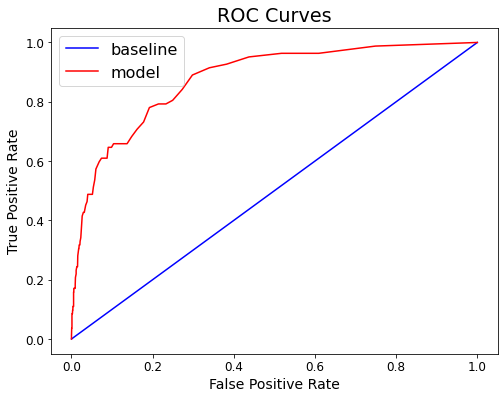

In [157]:
evaluate_model(test_labels, train_labels, rf_predictions,
               rf_probs, train_rf_predictions, train_rf_probs)
